# Are Homes Becoming More Energy Efficient in England and Wales?

In this project, we will try to answer the question of whether homes are becoming more energy efficient across England and Wales, using Energy Performance Certificate data for the years 2008-2022.

### Background

#### What is an EPC?
Across the UK, properties are given an EPC, which indicates how energy efficient the property is, and the ways in which it could improve. This is conveyed in a number of categories such as heating, lighting and insulation, however the most common way of discussing a property's EPC is via it's rating. These range from A (best) to G (worst). An example of a full EPC can be found via [this UK government link](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/5996/2116821.pdf), and a snapshot of the EPC rating section is below.

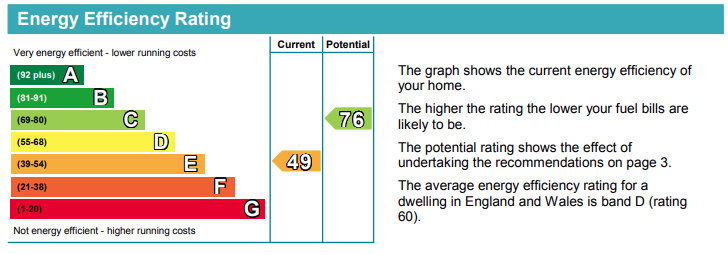

EPCs are valid for 10 years, though domestic ones are usually only renewed when the EPC is expired <i>and</i> the property is either to be sold or a new rental agreement is required.

#### Problem statement

There have been recent measurements and legislative changes around the EPC ratings for some households in England and Wales - we want to see whether these changes have had an impact on energy performance across those nations.

The UK Government estimates that in 2021, just under 20% of the UK's greenhouse gas emissions came from the residential sector([source](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1064923/2021-provisional-emissions-statistics-report.pdf)). With a Net Zero target date of 2050, the UK Government still has some way to go in improving the energy efficiency of homes. One way of measuring progress on this front is via changes to EPC ratings over time.

In 2018, the **Minimum Energy Efficiency Standards (MEES)** were introduced for the private rental sector across England and Wales. Since that year, new tenancy agreements and renewals of existing rental agreements require the property to be EPC rated E or above. Previously, properties with EPC ratings of F and G were acceptable (read more via the [Gov.uk Guidance](https://www.gov.uk/guidance/domestic-private-rented-property-minimum-energy-efficiency-standard-landlord-guidance)).

While the MEES are restricted to the private rental sector, in 2021 this sector represented approximately 20% of all households in England ([source](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1000052/EHS_19-20_PRS_report.pdf)), and 17% in Wales ([source](https://www.gov.wales/housing-wales-census-2021-html)). The impact of these changes could be substantial, depending on the pre-2018 distribution of ratings across the sector.

Private renter charity <i>Generation Rent</i> estimates in London that nearly 30% of households are private tenants ([source](https://www.generationrent.org/about_renting)). So the impact in London may be even greater.

#### What data will we use?

We can use EPC ratings data to measure the pre-MEES state of the domestic property sector, and the impact MEES may have had post 2018.

Each quarter, data on newly registered EPCs is published on the UK Government's website. We will be using table D3 from [UK Government's Live tables on Energy Performance of Buildings Certificates](https://www.gov.uk/government/statistical-data-sets/live-tables-on-energy-performance-of-buildings-certificates), entitled the snappy <i>'domestic Energy Performance Certificates for all dwellings by floor area, size, energy use, carbon dioxide emissions and fuel costs'</i>.

We'll look at this data on an annual basis. We'll also look at how the EPC ratings may differ over time between LAs within London and those outside of London.


### Data Importing and Cleaning

In [ ]:
#Importing the initial libraries we will need

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#I've used Excel to get just the relevant part of the dataset and save it as a csv, so just importing that 

csv = 'dataset_2.csv'
data = pd.read_csv(csv)
df = pd.DataFrame(data)

In [ ]:
df.head(3)

I don't personally like using column names with a mix of capitalisation and spaces. Let's clean this up.

In [ ]:
#making column names simpler to use. Create list, fix, replace columns with new list.

cols = df.columns.to_list()

#cleaning column names

new_cols = []

for item in cols:
    item = item.lower() #lowercase
    #a series of punctuation fixes
    item = re.sub(' ','_', item)
    item = re.sub(r'\(','', item)
    item = re.sub(r'\)','', item)
    item = re.sub(r'/','', item)
    #item = re.sub(r'£','', item)
    item = re.sub('__','_', item)
    new_cols.append(item)

df.columns = new_cols

df.info()

### Our columns:
**local_authority_code** : the Office of National Statistics (ONS) code for the local authority (typically, county or London Borough).<br>
**local_authority**: name of the local authority<br>
**quarter**: quarter in which the data was collected<br>
**number_of_lodgements**: number of properties with new EPCs registered that quarter<br>
**total_floor_area_m2**: total floor area of all the properties combined, in metres squared<br>
**Columns a through g**: number of properties with a given EPC rating from A to G<br>
**not_recorded**: number of properties not given an EPC rating

I'm going to now clean up the rows. We'll need to:
- Covert any numbers with commas to floats
- Change the quarterly data to datetime format
- Remove any NA data

In [ ]:
#converting the number columns to floats
df.iloc[:,3:] = df.iloc[:,3:].replace(',','', regex=True).astype(float)

In [ ]:
#converting the quarter format to datetime
df['quarter'] = df['quarter'].replace('/', '-Q', regex=True)
df['quarter'] = pd.to_datetime(df['quarter'])

In [ ]:
df = df.replace(r'Unknown', np.NaN, regex=True)

In [ ]:
df = df.dropna()
df.head(3)

In [ ]:
#Let's understand how spread our data is

largest_la = df[df['number_of_lodgements'] == df['number_of_lodgements'].max()]
smallest_la = df[df['number_of_lodgements'] == df['number_of_lodgements'].min()]

print('Largest local authority by lodgements =\n {}'.format(largest_la[
    ['local_authority', 'quarter', 'number_of_lodgements']]))
print('\n')
print('Smallest local authority by lodgements =\n {}'.format(smallest_la[
    ['local_authority', 'quarter', 'number_of_lodgements']]))

In [ ]:
plt.hist(df['number_of_lodgements'], bins=100)
plt.title('Number of lodgements')
plt.show()

In [ ]:
df['number_of_lodgements'].describe()

The number of properties registered with a new EPC each quarter averages at 1246, however there is a standard deviation of over 1000 and the minimum is 1. We have quite a spread in the size of the datasets we'll use to compare local authorities, so we will address that in the next section.

### Analysis 1: Finding the best and worst performing regions

As a way to familiarise ourself with the data, let's find the top 10 and bottom 10 local authorities (LAs) in terms of their ratings for 2022.

Method:
- Working quarterly data is unnecessarily precise for this study, so instead I am going to sum the data by year for each LA.
- With the LAs differing so vastly in size, a simple count of lodgements does not tell us much. Instead, we'll work with percentages. This isn't ideal either when comparing region-to-region, however we will later be looking at changes within regions over time, and the percentages will be more helpful then. For the time being and a quick lookover, they will suffice.
- We'll use nlargest() to find the regions with the highest percentages of A-rated and G-rated EPC properties.

In [ ]:
df = df.copy(deep=True)

In [ ]:
#Summing by year for each region

#getting the year
df['year'] = df['quarter'].dt.year
#new groupby dataframe to sum quarterly counts into yearly counts, by local authority
df_years = df.groupby(['local_authority_code','local_authority','year'])[['number_of_lodgements'
                                                                          ,'a'
                                                                          ,'b'
                                                                          ,'c'
                                                                          ,'d'
                                                                          ,'e'
                                                                          ,'f'
                                                                          ,'g'
                                                                          ,'not_recorded']].sum()

In [ ]:
df_years.head(3)

In [ ]:
df_years = df_years.reset_index()

Part of our aim with this study is to compare changes in London LAs (aka London Boroughs) with LAs outside of London. So we're going to add a column that helps us easily differentiate between the groups.

The ONS LA labeling standards make this quite easy, as London Boroughs have local authority codes beginning with the code E09.

In [ ]:
#Adding a boolean column to check if a local authority is a London Borough

df_years['is_greater_london'] = df_years['local_authority_code'].str.contains('E09')

In [ ]:
#Creating a function that will automatically calculate the
#percentage of properties lodged under each grade for each local authority, every year

ratings = ['a','b','c','d','e','f','g']

def percentager(dataframe):
    for item in ratings:
        dataframe['percentage_'+item] = round(100*(dataframe[item]/dataframe['number_of_lodgements']),2)
    return dataframe

In [ ]:
df_years = df_years.apply(percentager, axis=1)

In [ ]:
#Finding the top 10 performing regions in 2022 - i.e. those with the most A rated EPC properties

most_a = df_years[df_years['year'] == 2022].nlargest(10, 'percentage_a')
most_a.head(5)

In [ ]:
ax1 = sns.barplot(data=most_a, x='local_authority', y='percentage_a', color='lightgreen')
plt.xlabel('Local Authority')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.title('Percent of EPC A-rated domestic properties:\n Top 10 Local Authorities, England and Wales 2022')
plt.show()
plt.savefig('pct_a_rated.jpg')

In [ ]:
#Bottom 10 performing regions - i.e. those with the most G rated properties in 2022
most_g = df_years[df_years['year'] == 2022].nlargest(10, ['percentage_g']).sort_values(by='percentage_g',
                                                                                      ascending=False)

In [ ]:
ax2 = sns.barplot(data=most_g, x='local_authority', y='percentage_g', color='red')
plt.xlabel('Local Authority')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.title('Percent of EPC G-rated domestic properties:\n Top 10 Local Authorities, England and Wales 2022')
plt.show()

plt.savefig('pct_g_rated.jpg')

In [ ]:
las_with_a_london = len(most_a[most_a['is_greater_london'] == True])
las_with_g_london = len(most_g[most_g['is_greater_london'] == True])

print('Count of London Boroughs in top 10 for A-rated EPCs, 2022: {}'.format(las_with_a_london))
print('Count of London Boroughs in top 10 for G-rated EPCs, 2022: {}'.format(las_with_g_london))

So far we can see that the 9/10 of the areas with the most newly-lodged A-rated EPC properties in 2022 were in London Boroughs. In contrast, 0/10 of the regions with the most newly-lodged G-rated EPC properties were in London. Of this group, 5 were in Wales, 3 in Devon and Cornwall, and 2 in the north of England (Ryedale, Eden).

However, there is a sizable difference of scale between the top 10 A-rated groups and the top 10 G-rated groups. G-rated properites seem to take up quite a small number of new lodgements in 2022, at most just under 6% in the worst performing local authority (Gwynedd). Compare that to the LAs with the most A-rated properties, where in 10th place Havering still had over 12% of new lodgements rated A. 

Seeing as the MEES changes impact everything below E-ratings, perhaps instead we should look at G and F rated properties together for more insight and a better sense of scale.

In [ ]:
#Bottom 10 performing regions - i.e. those with the most F AND G combined rated properties in 2022

df_years['f_and_g'] = df_years['percentage_f'] + df_years['percentage_g']

most_f_and_g= df_years[df_years['year'] == 2022].nlargest(10,['f_and_g']).sort_values(by='f_and_g', ascending=False)
most_f_and_g.head(3)

In [ ]:
ax3 = sns.barplot(data=most_f_and_g, x='local_authority', y='f_and_g', color='coral')
plt.xlabel('Local Authority')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.title('Percent of EPC F- & G-rated domestic properties:\n Top 10 Local Authorities, England and Wales 2022')
plt.show()

plt.savefig('pct_f_g_rated.jpg')

In [ ]:
mean_f_and_g = round(most_f_and_g['f_and_g'].mean(),2)
print('Average % of lodgements in the the worst performing areas at rating F or G = {}%'.format(mean_f_and_g))

The average is quite high and it looks like it is being skewed by Scilly. We know from earlier that Scilly is one of the smallest LAs, reporting just 1 property in some quarters, so it might not be too representative of a dataset. We'll quickly take a look at the same data above, but remove Scilly as an outlier. Below shows that there were 48 lodgements for that region in 2022, the smallest reporting region in the 2022 data, and is behind the 2nd smallest reporting region by nearly a factor of 10 (City of London)

In [ ]:
#Top 3 Local Authorities with the fewest lodgements in 2022
df_years[df_years['year'] == 2022].nsmallest(3,'number_of_lodgements')

In [ ]:
#The mean without Scilly in the top 10
mean_most_f_and_g_no_scilly = most_f_and_g.iloc[1:,-1].mean()
print('Average % of lodgements in the the worst performing areas at rating F or G, excluding Isles of Scilly = {}%'.format(mean_most_f_and_g_no_scilly))

To be fair, removing Scilly doesn't drop the average too much!

Let's see what else we can disover about the 2022 data for F and G rated properites. How is the spread for all the English and Welsh LAs in terms of the proportion of properites registered with these ratings?

In [ ]:
df_2022 = df_years[df_years['year'] == 2022]
df_2022['f_and_g'].describe()

In [ ]:
ax4 = plt.hist(df_2022['f_and_g'], bins=50)
plt.title('Combined percent of F and G lodged properties in 2022')
plt.show()

plt.savefig('f_g_hist.jpg')

The names on our list of local authorities with the most F and G lodged properties combined in 2022 is not too different to the names listed in the G-only chart.

5 of the top 10 in this list are again are in Wales, two in Norfolk, two in the Cornwall area (Isles of Scilly being off the cost of Cornwall) and 1 in the north of England (Eden). None are in London.

We can see that in these worst-performing regions, F and G rated properties accounted for 20.02% of new lodgements in 2022 (including Scilly). The average for the England and Wales overall in 2022 is 5.3%, and the standard deviation is 3.9. So, we can conclude that the areas in the top-10 poorly performing regions are at the extreme end of the scale.

As the mean shown above is around 5%, our of interest, lets find out what percentage of regions with > 5% F and G rated properties are in London vs outside London in 2022.

In [ ]:
#percentage to calculate
pct = 5

#filter for London data
london_greater_than_x_pct_f_g = df_years[(df_years['year'] == 2022) 
                                   & (df_years['f_and_g'] >= pct)
                                   & (df_years['is_greater_london'] == True)].sort_values(by='f_and_g')

#filter for non-London data
non_london_greater_than_x_pct_f_g = df_years[(df_years['year'] == 2022) 
                                   & (df_years['f_and_g'] >= pct)
                                   & (df_years['is_greater_london'] == False)].sort_values(by='f_and_g')


total_non_london = non_london_greater_than_x_pct_f_g['is_greater_london'].value_counts().sum()
total_london = london_greater_than_x_pct_f_g['is_greater_london'].value_counts().sum()

print('Number of non-London Boroughs with >{}% F and G EPC rated properties registered in 2022 = {}'
      .format(pct, total_non_london))


print('Number of London Boroughs with >{}% F and G EPC rated properties registered in 2022 = {}'
      .format(pct, total_london))

proportion_non_london = round(100*(total_non_london)/len(df_years['local_authority'].unique()),2)

print('\nNon-London Boroughs as a percent of all LAs with >5% F and G EPC rated properties registered in 2022 = {}'
      .format(proportion_non_london) + str('%'))

There is quite a staggering difference between the capital and the rest of England and Wales in 2022. 

Just 1 London borough had >5% of it's properties registered as F or G rated in 2022, compared to outside the capital where 127 regions, or over 1/3 of regions overall, had >5% of their registered properties in 2022 rated F or G.

### Analysis 2: How has the number of F and G rated properties changed over the years?

In this section, we're going to consider how the percentage of F and G rated properties has changed over the years. We'll continue to consider the London vs outside-London trends when answering this question.

Below, we will create a bar chart showing us the percent of local authorities with >5% (the mean from earlier) of their new EPCs rated F and G each year. We'll separate London from non-London LAs to see if there is a difference in trends over time between these groups.

In [ ]:
#Finding the total number of London and non-London local authorities - helpful for later calcs
london_filter = df['local_authority_code'].str.contains('E09')

total_london_las = len(df[london_filter].local_authority.unique())
total_non_london_las = len(df[~london_filter].local_authority.unique())

In [ ]:
#Creating filtered df of London Boroughs with >5% F and G properties, all years
london_f_g_x_pct = df_years[(df_years['f_and_g'] >= pct)
                                   & (df_years['is_greater_london'] == True)].sort_values(by='f_and_g')

#Creating filtered df of non-London LAs with >5% F and G properties, all years
non_london_f_g_x_pct = df_years[(df_years['f_and_g'] >= pct)
                                   & (df_years['is_greater_london'] == False)].sort_values(by='f_and_g')

In [ ]:
#Using groupby on both the above dfs to get a count of the local authorities by year
grouped_london = london_f_g_x_pct.groupby('year', as_index=False)['local_authority'].value_counts()
grouped_non_london = non_london_f_g_x_pct.groupby('year', as_index=False)['local_authority'].value_counts()

#Summing the above counts
london_f_and_g = pd.DataFrame(grouped_london).groupby('year', as_index=False)['count'].sum()
non_london_f_and_g = pd.DataFrame(grouped_non_london).groupby('year', as_index=False)['count'].sum()

In [ ]:
#Calculating the percentage of F and G properties each year
#out of the total Local Authorities for that area
# (i.e. London has 33 LAs, non-London has over 309)

london_f_and_g['pct_of_total_las'] = round(100*london_f_and_g['count']/total_london_las,2)
non_london_f_and_g['pct_of_total_las'] = round(100*non_london_f_and_g['count']/total_non_london_las,2)

In [ ]:
non_london_f_and_g

In [ ]:
london_f_and_g

In [ ]:
#Plotting

ax5 = sns.barplot(data=london_f_and_g, x='year', y='pct_of_total_las'
                  , color='purple', label='London LAs')
ax6 = sns.barplot(data=non_london_f_and_g, x='year', y='pct_of_total_las'
                  , color='hotpink', alpha=.5, label='Non-London LAs')
plt.xlabel('year')
plt.xticks(rotation=90)
plt.ylabel('percentage')
plt.title('Percent of London vs non-London Local Authorities\nwith >5% EPC F and G rated properties by year')

handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels)

plt.show()

plt.savefig('f_g_5pct.jpg')

It looks as though both London and the wider non-London local authorities of England and Wales have seen a drop in the percentage of properties with F and G ratings over time. However, the trend has been more pronounced in London versus outside of London, particularly since 2019. 

This coincides nicely with the timing of the MEES regulations.

Below, we will use linear regression to compare the speed with which London LAs are reducing the proportion of F and G rated properties, versus non-London LAs.

In [ ]:
#Find regression trend of both groups

#First, the London Data

from sklearn.linear_model import LinearRegression

# Training data
X_london = london_f_and_g.loc[:, ['year']]  # features
y_london = london_f_and_g.loc[:, 'pct_of_total_las']  # target

# Train the model
model = LinearRegression()
model.fit(X_london, y_london)

y_pred_london = pd.Series(model.predict(X_london), index=X_london.index)

In [ ]:
#Second, the non-London data

# Training data
X_non_london = non_london_f_and_g.loc[:, ['year']]  # features
y_non_london = non_london_f_and_g.loc[:, 'pct_of_total_las']  # target

# Train the model
model = LinearRegression()
model.fit(X_non_london, y_non_london)

y_pred_non_london = pd.Series(model.predict(X_non_london), index=X_non_london.index)

In [ ]:
#Replotting the chart above, with the regression lines

ax7 = y_pred_london.plot(label='London LAs trend', color='purple')
ax8 = y_pred_non_london.plot(label='Non-London LAs trend', color='hotpink')


ax5 = sns.barplot(data=london_f_and_g, x='year', y='pct_of_total_las'
                  , color='purple', label='London LAs')
ax6 = sns.barplot(data=non_london_f_and_g, x='year', y='pct_of_total_las'
                  , color='hotpink', alpha=.5, label='Non-London LAs')
plt.xlabel('year')
plt.xticks(rotation=90)
plt.ylabel('percentage')
plt.title('Percentage of London vs non-London Local Authorities\nwith >5% EPC F and G rated properties by year')

handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels, bbox_to_anchor=(1, 1))

plt.show()

plt.savefig('f_g_5pct_with_trends.jpg')

From the above lines of regression we can confirm that London Boroughs have had a steeper, and therefore faster and more dramatic decrease in the percentage of F and G EPC rated properties being registered per year, compared to Local Authorities outside of London. 

Both regions show a decline in the overall percent of F and G rated properties being registered, indicating that property energy efficiency over England and Wales is increasing. 

While we can't for certain say that the MEES regulations have impacted all of this change, the timing of dramatic decrease in the number of F and G properites between 2018 and 2019 could be quite telling. More data on rental-specific EPC ratings would be needed to confirm this. For example, the drop could also be the result of more landlord simply having their out-of-date EPCs renewed as a result of pressure from the changes, and these properties may have been preforming above F or G standards for a number of years beforehand.

However, with London being such a huge city with a greater proportion of household renting privately than the rest of the country, it is reasonable to think that this dramatic drop in the years after 2018 at least somewhat reflects the value of the MEES reforms.


We can build on the picture above by plotting the proportion of <i>all</i> EPC ratings across the years. We'll do that below with the London and non-London data separated once more. This time, we'll create a stacked bar chart, which will use the years as the X-axis and the the mean percentage of each rating across the local authorities as the Y-axis.

#### London

In [ ]:
#Want to creat a stacked bar chart of London Borough EPC ratings over the years

#Creating a filter for just years and EPC rating percentages in London Boroughs
needed_cols = ['year','percentage_a', 'percentage_b', 'percentage_c',
           'percentage_d', 'percentage_e', 'percentage_f', 'percentage_g']

pct_cols = ['percentage_a', 'percentage_b', 'percentage_c',
           'percentage_d', 'percentage_e', 'percentage_f', 'percentage_g']

london_pcts = df_years[(df_years['is_greater_london'] == True)][needed_cols]

#As we have data for many Boroughs, will take the mean
#percentage of properties in each rating per year, via a groupby

london_pcts_mean = london_pcts.groupby('year')[pct_cols].mean()

In [ ]:
london_pcts_mean

In [ ]:
#I want to create a stacked barchart with the data above to visualise how the proportions change over time
label = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
london_pcts_mean.plot(kind='bar', stacked=True, color=['green','limegreen', 'greenyellow','gold','orange',
                                                       'tomato', 'firebrick'])
plt.legend(bbox_to_anchor=(1.2,1), loc='upper right', labels=label, title='EPC Rating')
plt.title('Mean London EPC rated property registrations annually')
plt.ylabel('percent')

plt.show()

plt.savefig('stacked_london.jpg')

We can see from the above chart that London overall has seen an increase in the proportion of higher-grade properties being registered yearly, compared to properties with rating E or lower. It appears that properties with a C or D rating have become the most commonly registered groups since 2018, again coinciding with the introduction of MEES.

I'll create the same chart for LAs outside of London and see how it compares

#### Non-London

In [ ]:
#Filter for non-London Local Authorities
non_london_pcts = df_years[(df_years['is_greater_london'] == False)][needed_cols]

#As we have data for many LAs, will take the mean
#percentage of properties in each rating per year, via a groupby
non_london_pcts_mean = non_london_pcts.groupby('year')[pct_cols].mean()
non_london_pcts_mean

In [ ]:
non_london_pcts_mean.plot(kind='bar', stacked=True, color=['green','limegreen', 'greenyellow','gold','orange',
                                                       'tomato', 'firebrick'])
plt.legend(bbox_to_anchor=(1.2,1), loc='upper right', labels=label, title='EPC Rating')
plt.title('Non-London mean EPC rated property registrations')
plt.ylabel('percent')

plt.show()

plt.savefig('stacked_non_london.jpg')

The trends here are similar to those of London. For example, there is an increase in the proportion of properties with rating D or higher since around 2017.

Overall, E or lower rated properties are becoming a smaller proportion of the overall property stock outside of London, being displaced by D and C rated properties.

One of the more notable differences between the London and non-London stacked charts is that A-rated properties are much more common in the capital. One explanation might be that upgrading a home's energy efficiency does not always come cheaply. The relative difference in wealth in London versus the rest of England and Wales is well documented, and this may be reflected in the ability of London landlords and homeowners in to invest in their homes to a greater degree than in regional areas. 

Another explanation could be that the very comepetitive element of London property market means that customers (in particular, property buyers) expect better EPC standards from their properties, and have the ability to be fussier about energy ratings, leading to overall standards increasing.

# Analysis 3: Within-LA changes over time, and distribution overall.

To get a clearer idea of the distribution of ratings across England and Wales, I now want to plot our EPC ratings for each local authority on a map. The map will include a slider so we can also scroll through the years, and see how the EPC ratings change over time both within individual LAs, and across England and Wales as a whole.

The Local Authority boundary data I'm using is from the Office of National Statistics 2021 dataset, which can be found [here](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-december-2021-uk-bfc-1/about). This dataset is actually quite large, so I have used a condensed version found via StackOverflow ([Github link here](https://github.com/thomasvalentine/Choropleth/blob/main/Local_Authority_Districts_(December_2021)_GB_BFC.json), thank you so much to the creator!). 

We'll create two such charts. One that looks at the percent of F and G rated properties annually, and one that looks at the perecent of A, B and C rated properties annually.

In [ ]:
import geopandas as gpd

In [ ]:
#Create column for E, F and G
#df_years['efg'] = df_years['percentage_e'] + df_years['percentage_f'] + df_years['percentage_g']

In [ ]:
#Reading our json file ahead of time to see if it's going to fit our needs
gj = gpd.read_file('condensed_uk_local_authorities_2021.json')

In [ ]:
#Checking the shape
gj.plot(figsize=(3,3))

We can see from the map plot above that the GeoJSON file includes all local authorities in the UK. Our EPC dataset is just for Wales and England, so we can drop the entries for Scotland and Northern Ireland.

In [ ]:
#Removing Northern Irish and Scottish local authorities
ni_scot_filters = (gj['LAD21CD'].str.startswith('N')) | (gj['LAD21CD'].str.startswith('S'))
gj_ew_only = gj[~ni_scot_filters]

In [ ]:
#Check map looks OK - should show just English and Welsh local authorities now
gj_ew_only.boundary.plot()

This looks like the right sort of thing. Perfect.

In [ ]:
import plotly.express as px

import json


lat = 53.16972805776037
lon = -2.1522074544910885

fig = px.choropleth_mapbox(df_years,
                           geojson=gj_ew_only,
                           locations='local_authority',
                           color='f_and_g',
                           featureidkey="properties.LAD21NM",
                           color_continuous_scale=px.colors.sequential.OrRd,
                           mapbox_style="carto-positron",
                           center={"lat": lat, "lon": lon},
                           zoom=5.5,
                           range_color=[0,25],
                           animation_frame='year',
                           labels={'f_and_g':'Percent'},
                           title='Percent of EPC F and G rated properties registered annually'
                          )

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.write_html("FG.html") 
fig.show()


It looks like I am missing some data for some years/regions. A hover over the map shows the relevant counties are Buckinghamshire, West Northamptonshire and North Northamptonshire.

Was this data in the original dataset? A quick check below:

In [ ]:
#Our originally imported and cleaned dataframe was called df

missing_data_las = df[(df['local_authority'] == 'Buckinghamshire') | 
         (df['local_authority'] == 'North Northamptonshire') |
         (df['local_authority'] == 'West Northamptonshire')]
missing_data_las['year'].unique()

Looks like a 'no'! Those counties only have data since 2020 in the original dataset. That's OK, we can live without this information.

We'll now create the same plot, but this time with the sum of the A, B and C ratings each year.

In [ ]:
#Summing each year's A, B and C rating percentages.
df_years['abc'] = df_years['percentage_a'] + df_years['percentage_b'] + df_years['percentage_c']

In [ ]:
import plotly.express as px

import json


lat = 53.16972805776037
lon = -2.1522074544910885


fig = px.choropleth_mapbox(df_years,
                           geojson=gj_ew_only,
                           locations='local_authority',
                           color='abc',
                           featureidkey="properties.LAD21NM",
                           color_continuous_scale="Viridis",
                           mapbox_style="carto-positron",
                           center={"lat": lat, "lon": lon},
                           zoom=5.5,
                           range_color=[0,50],
                           animation_frame='year',
                           labels={'abc':'Percent'},
                           title='Percent of EPC A, B, or C properties registered annually'
                          )

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.write_html("ABC.html")                           
fig.show()


### Maps Discussion

#### F and G ratings
In the first map, scrolling through time reveals clearly that the percentage of newly lodged F and G EPC ratings is declining across England and Wales. The map is noticably paler in 2022 compared to 2008.

There is a fluctuation in the data. We can see that between 2008 and 2015, the trend overall is toward fewer F and G ratings, however 2016 looks quite dark again. The trend towards improvement then continues post-2016. This 2016 spike is also reflected in our stacked bar charts.

Some regions do not seem to show much improvement over time, compared to the rest of the country. These are by-and-large the same LAs we noted in our top-10 regions with the highest F & G ratings for 2022. Largely, LAs in Wales, Cornwall and surrounding areas, north Northfolk and the north of England lag behind central England and most metropolitan areas in terms of reducing the proportion of F and G ratings each year.

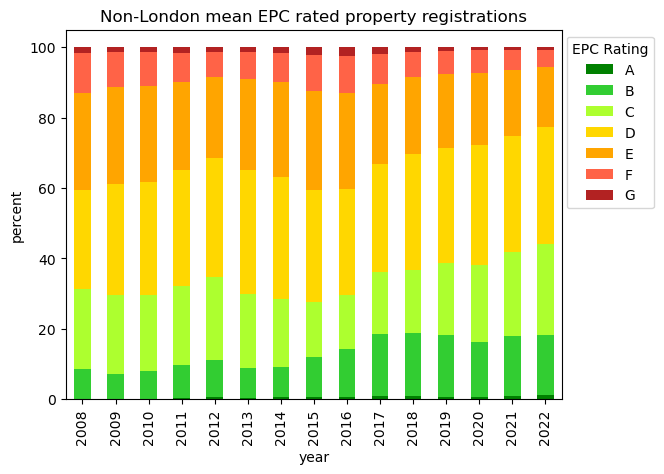

#### A, B and C ratings

The reason to look just at A, B and C ratings over time (rather than D and/or E) is that we can see from the stacked bar charts that the proportion of D and E properties over time does change, but not a great deal. We can see a bit of this trend with the interquartile range below:

In [ ]:
df_years['de'] = df_years['percentage_d']+df_years['percentage_e']
 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.tight_layout(pad=2.5)

ax1.boxplot(x=df_years[df_years['year'] == 2008]['de'], vert=False)
ax1.set_title('Percent D and E rated properties registered by year\n\n2008')
ax1.yaxis.set_major_locator(MultipleLocator(100))

ax2.boxplot(x=df_years[df_years['year'] == 2018]['de'], vert=False)
ax2.set_title('2018')
ax2.yaxis.set_major_locator(MultipleLocator(100))

ax3.boxplot(x=df_years[df_years['year'] == 2022]['de'], vert=False)
ax3.set_title('2022')
ax3.yaxis.set_major_locator(MultipleLocator(100))

plt.savefig('boxplots_de_certs.jpg')
plt.show()

If we look at the map for A, B and C combined data, there is a lightening trend between the 2008 and the 2022 data - indicating an overall shift toward more higher EPC rated properties.

The picture is not as clear-cut as the F and G map. There are certainly areas that continue to lag behind by 2022, and a lot of them overlap with the lagging areas noted in our analysis of the F and G map - Wales outside the cities, non-metropolitan northern England, north Norfolk. Higher percentages of A, B and C ratings are clustered in central England, metropolitan regions and London.

Nevertheless, the difference between the 2008 map and the 2022 map is very striking in terms of the depth of change - the interquartile range and the mean from 2008 is much lower than the same in 2022, and the change is already visible in the 2018 data (below). The same chart is also plotted for the F and G rated properties, for comparison, and in that we can see the size of the interquartile range has also shrunk and moved further toward 0 - indicating that LAs are having both a smaller and more consistent percentage of lower rated properties registered each year.

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.tight_layout(pad=2.5)

ax1.boxplot(x=df_years[df_years['year'] == 2008]['abc'], vert=False)
ax1.set_title('Percent A, B and C rated properties registered by year\n\n2008')
ax1.yaxis.set_major_locator(MultipleLocator(100))

ax2.boxplot(x=df_years[df_years['year'] == 2018]['abc'], vert=False)
ax2.set_title('2018')
ax2.yaxis.set_major_locator(MultipleLocator(100))

ax3.boxplot(x=df_years[df_years['year'] == 2022]['abc'], vert=False)
ax3.set_title('2022')
ax3.yaxis.set_major_locator(MultipleLocator(100))

plt.savefig('boxplots_abc_certs.jpg')
plt.show()

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.tight_layout(pad=2.5)

ax1.boxplot(x=df_years[df_years['year'] == 2008]['f_and_g'], vert=False)
ax1.set_title('Percent F & G rated properties registered by year\n\n2008')
ax1.yaxis.set_major_locator(MultipleLocator(100))

ax2.boxplot(x=df_years[df_years['year'] == 2018]['f_and_g'], vert=False)
ax2.set_title('2018')
ax2.yaxis.set_major_locator(MultipleLocator(100))

ax3.boxplot(x=df_years[df_years['year'] == 2022]['f_and_g'], vert=False)
ax3.set_title('2022')
ax3.yaxis.set_major_locator(MultipleLocator(100))

plt.savefig('boxplots_fg_certs.jpg')
plt.show()

## Conclusions

The data from the Government's live EPC quarterly reporting supports the idea that it is likely the MEES legislation has had a positive impact on EPC ratings for properties in England and Wales.

The proportion of lower, F and G rated properties given new certificates each year has dropped significantly between 2008 and 2022. Most notably, the pace of this drop accelerated in London, but the same can still be said of properties in local authorities outside of London.

By the same token, properties with higher ratings of A, B and C have increased since 2008, again with a stronger upward trend since 2018. This has not been as strong a trend as the drop in F and G rated properties, as a lot of those have been absorbed into the D and E ratings.

### Possible next steps for further energy reductions in residential sector
#### Homeowners
The government has much less authority over homeowners rather than it does with private landlords, so introducing MEES-like legislation to this group of the residential sector is unlikely. Other incentives such as grants or loans to help with the cost of improving home energy efficiency could help, however there are already many such schemes in place in England. Nevertheless, these could be expanded and/or better advertised to homeowners. Penalties for having a lower-rated house seem an unlikely choice, as such things could disproportionately affect poorer households.

#### Private rentals
The MEES legislation also extends to non-domestic private rentals. In this part of the regulations there are plans to tighten the standards, so that properties must reach EPC rating C by 2027 at the latest, and EPC rating B by 2030. A similar tightening might see an improvement for private tenants in their energy bills, however it might also mean more landlords choose to leave the rental market rather than make the necessary investments - meaning private tenants lose out in the end.

#### Social housing
The Social Housing Decarbonisation Fund (SHDF) was set up by the UK Government in 2021 to help social housing providers in English local authorities to upgrade their properties to a minimum rating of EPC C. The deadline for these upgrades is 2035, and 2030 for fuel poor households. Find out more [here](https://www.gov.uk/government/publications/social-housing-decarbonisation-fund-wave-2) and [here](https://www.housing.org.uk/news-and-blogs/news/social-housing-decarbonisation-fund-second-wave-successful-bids-announced/). Without knowing the to which category of property new EPC certificates belong, we can't say at this time whether the SHDF is already having an impact. More years of data are likely needed too before this can be judged with satisfaction.
